___
# Predictive Power - Interest rates and GDP Growth
___

### TOC
- [Intro](#intro)
- [Method](#method)
___
## Intro <a id="intro"></a>
___

The consensus across all schools of economics on this subject is that changes in interest rates lead to changes in GDP Growth. Given the physics-envy hued paradigm upon which economic thinking is based, this makes perfect sense; the more expensive money is, the less of it is demanded and vice verca. The big societal application of this idea is monetary policy; rates are raised with the intention of slowing the economy, lowered to get it moving. While it makes perfect valid sense in the paradigm, there is reason to doubt that this idea is actually sound. For example:
<img src="images/gdp_interest/mystery_country.png"/>



This mystery country's nominal GDP growth (in green) and interest rate (red) appears to be a counter example to the idea. There are parts of this plot that appear to be in line with the theory, for example, falling $r$ from 1960 until before that spike in 1973ish, accelerating ($\delta$GDP is already a rate of change) GDP growth coincides with declining $r$, and then the spike that follows directly after coincides with a large decelerating impulse in GDP growth. It all more or less looks fine until just before 1990 where things stop working pretty much completely. For an idea that is taken as so naturally self evident at face value, that's at least a little weird. This is, of course, the infamous macroeconomic mystery of Japanese nominal GDP growth and interest rate.

[The paper by Richard Werner](https://www.sciencedirect.com/science/article/pii/S0921800916307510) which inspired me to attempt this exercise in analysis and gesticulation, goes into more examples at greater depth so I won't spend too much time here, but I did want to raise a quote from the paper to our attention:

> As an empirical matter, low interest rates are a sign that monetary policy has been tight - in the sense that the quantity of money has grown slowly; high interest rates are a sign that monetary policy has been easy - in the sense that the quantity of money has grown rapidly. The broadest facts of experience run in precisely the opposite direction from that which the financial community and acedemic economists have all generally taken for granted.
>
> – Milton Friedman, 1968

#### Predictive Power, Causality, more Gesticulation
I want to see if a fast-and-loose (very ***very*** loose) approach can hint at bits and pieces this empirical study rigorously uncovers. What would constitute an ovewhelming success would be if I can show with my primitive sticks and stones and limited knowledge of statistics that one could be suspicious of the hypothesis that interest rates determine GDP growth. In particular, I'm quite curious about predictive power - whether or not [PPS](https://8080labs.com/blog/posts/rip-correlation-introducing-the-predictive-power-score-pps/) out of the box has something to say either in favour of or agaisnt the null hypothesis, and i'm also interested in trying my hand at [Granger causality](https://en.wikipedia.org/wiki/Granger_causality). These two things could work syngergistically and It's also something I want to apply across to my health data as well.

A personal goal is in identifying rabbit holes for me to explore. Since my statistical education is piecemeal and hacky, there's so much rigorour which I don't know that I don't know. This is a way of revealling my own ignorance to myself.

In the study, a few countries are analysed - Germany, Japan, United Kingdom, United States, and it is found that all but Germany comfortably destroy the $H_0$. In the case of Germay, it is only shaken violently off it's pedestol of hot air. Since the questions in question are with regards to the journey and the start and end points are part of the assumptions, whatever I yield on Germany, given that I take it on assumption to be diffferent, should be an interesting point of reference.

Werner does all sorts of stuff, much of which is beyond my current statistical undertanding, some things being certain statistical tests covering the weakness of any particular test, checking for stationarity and cointegration, similar. While this is a great idea for determining the facts in the first place, that isn't my goal. I replicate bits and pieces that I am capable of and where I understand the motivation and method. Beyond those things, I won't be copying much of what he did because I have no idea what most of it means or why it's important. Clearly it's important enough that he does the work but that's at least two levels beyond my current knowledge and goal for this exercise.

#### Method Discussion <a id="method"></a>

I'm going to roughly copy his method but modify bits and pieces to see if I can fill in the gaps I create for the sake of my curiosity. Thus, for German, Japanese and American (why not) data, I traverse the following path of thinking:

The two series are either correlated or not. Since one would expect uncorrelated series to not have much to do with each other, we would like to establish correlation first, then gesture in the direction of causality/forecasts. Using one timeseries to *forecast* another is sensible to me, but causality between timeseries struck me as a very strange subject and having done a bit of reading, it appears that the prima facie ontological murkiness is not lost on anyone.

For forecasting, I think we can just ballpark the intuition as something like: real event, $a$ registers as a change in timeseries $a$ which could also be more or less equivalent to the event's ontological manifestation (changing an interest rate, *announcing* that you're a willing buyer of last resort, similar). Real event $a$ also causes a second real event, $b$ which registers in timeseries $b$. So at the forecasting level, causality is time ordering the events then establishing confidence that, with temporality, $a \implies b$ but also that $\lnot b \implies \lnot a$... to some degree. In english, what we want is 1. every time $a$ occurs, we'll see an occurrence of $b$, but also, that 2. the absense of $b$ means there wasn't $a$. To make intuitive sense of that second part, if $b$ was to regularly occur without $a$ having happened, then we wouldn't be quite as confident that occurrences of $a$ make for a good signal that $b$ will come.

From the perspective of causality, there's holes in that thinking; $a$ could still have explanatory power regarding $b$ without being the only factor, just to name one. Apparently, Granger had a little rant in his nobel lecture on the whack conclusions one could and some have reach using his statistical tool. One last relevant thing I came across in my reading:

>An associational concept is any relationship that can be defined in terms of a joint distribution of observed variables, and a causal concept is any relationship that cannot be defined from the distribution alone... Every claim invoking causal concepts must be traced to some premise that invoke such concepts; it cannot be inferred or derived from statistical associations alone
>
> – Pearl

The insightful point that Pearl suggest and that I definitely take away is that in a way reminiscent of the old "can't ought from is", you can't derive conclusions about causality from observational data only; assumptions must be smuggled in as axioms since to speculate on causality necessarily involves theoretical matheme-ising. The point i'm making (to myself) is that the Granger causality test is not a test for causality proper ("proper") but rather, is probably a [kind of weak space-time contiguous forecast](https://en.wikipedia.org/wiki/Humean_definition_of_causality)


My intent for interest rates:
1. Grab correlations against GDP growth with lags
2. Repeat but with PPS
3. Do a granger causality and contextualise the relevant statistics

#### The Data

I use two sources for the data. I `get` the majority of it from the Federal Reserve Bank of St. Louis, and a few bits and pieces from The World Bank. Though the FRED sources much of the data I'm grabbing from The World Bank, WB also seems to impose lower bounds on the years i'm allowed to pull from, at least as far as I could find. FRED data goes back further than those lower bounds. On the other hand, the FRED doesn't have GDP data for Germany to a timescale I found satisfying, whereas The World Bank does. It's all a mess really.

Another significant problem is the matter of dates. The start and end of each series doesn't necessarily align and I can't hunt data forever, so i'm simply going to take the largest timespan I can for each country and perform the analysis on the available dates. The difficulty of acquiring nice data is also why i'm choosing years as my unit of time. It's as simple as I can make things.


So, From FRED, I will use:

- Annual-averaged non-seasonally adjusted nominal GDP for Japan and the US, measured in USD
- Annual-averaged interest rate/discount rate percentage per annum for Japan, Germany and the US

From The World Bank, I will use:

- German GDP


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import requests as re

### 1. Grab FRED

In [3]:
# --- Get FRED data

countries = ['DE', 'JP', 'US'] # de : germany, jp : japan, us : united states

fred_base = "https://api.stlouisfed.org/fred/series/observations\
?series_id={sid}\
&api_key={key}\
&units={units}\
&frequency=a&file_type=json\
"

# --- FRED API Key
with open("data/fred_key/auth.txt") as f:
    fred_key = f.read()

# --- Units
untransformed = "lin"
annual_change = "ch1"
percent_change= "pch"

# --- Dataset IDs
r_id = "INTDSR{c}M193N"    # Interest rate ID format c = country id
g_id = "MKTGDP{c}A646NWDB" # GDP ID format c = country id

# --- Get WB data
wb_base = 'http://api.worldbank.org/v2/country\
/{c}\
/indicator\
/{sid}\
?format=json\
{key}{units}\
'
wb_g_id = "NY.GDP.MKTP.CD"

In [4]:
def get_data(src="", key="", units="", series_id="", c=""):
    """
    Pull data from either source
    """
    url = src.format(sid=series_id, key=key, units=units, c=c)
    url = url.format(c=c)
    get = re.get(url)
    
    if get.status_code != 200:
        return get.status_code
    return get.json()

In [5]:
# --- Construct df

# 1. Grab FRED data and put it in a nice DF
# 2. Overwrite/append the data with WB for relevant fields

date_upper, date_lower = None, None
all_data = {}
realtime = None
cols = []

# --- FREDDY
for c in countries:
    dgdp = get_data(src=fred_base, key=fred_key, units=untransformed, series_id=g_id, c=c)
    r = get_data(src=fred_base, key=fred_key, units=untransformed, series_id=r_id, c=c)
    gets = {"r":r['observations'], "g":dgdp['observations']}
    
    for label, content in gets.items():
        data_store = {}
        for obs in content:
            # --- Realtime should be the same for all data
            if realtime == None:
                realtime = (obs['realtime_start'], obs['realtime_end'])
            
            d = pd.to_datetime(obs['date'])
            v = float(obs['value']) if obs['value'] != "." else np.nan

            # --- Earliest and Latest date DF index bounds
            if date_lower == None or d < date_lower:
                date_lower = d
            if date_upper == None or d > date_upper:
                date_upper = d

            # --- Append data
            data_label = "{c}_{l}".format(c=c, l=label).lower()
            entry = {"date" : d, data_label : v}
            data_store[d] = v
            all_data[data_label] = data_store
        cols.append(data_label)
        
df = pd.DataFrame(
    index=pd.date_range(start=date_lower, end=date_upper,freq="AS"),
    columns=cols,
    data = all_data)

print("Real time: ", realtime)

Real time:  ('2021-07-29', '2021-07-29')


In [6]:
display(df.iloc[15:20])

,de_r,de_g,jp_r,jp_g,us_r,us_g
1963-01-01,4.00,NaN,5.992500,6.949813e+10,3.23,6.386000e+11
1964-01-01,4.00,NaN,6.448333,8.174901e+10,3.55,6.858000e+11
1965-01-01,4.67,NaN,5.722500,9.095028e+10,4.04,7.437000e+11
1966-01-01,5.83,NaN,5.480000,1.056281e+11,4.50,8.150000e+11
1967-01-01,4.13,NaN,5.600000,1.237819e+11,4.19,8.617000e+11


In [7]:
# --- Take note of how .shift(lag) works

note = pd.DataFrame()
note["original jp_r"] = df.de_r.dropna()
note["shift jp_r by 1 "] = note["original jp_r"].shift(1).head()
note["shift jp_r by -1"] = note["original jp_r"].shift(-1).head()
note.head(3)

,original jp_r,shift jp_r by 1,shift jp_r by -1
1950-01-01,5.50,NaN,7.00
1951-01-01,7.00,5.5,6.13
1952-01-01,6.13,7.0,4.71


### Correlation and Correlation with Lags

Take the interest rate and $\Delta$gdp timeseries, shift rates backwards and forwards in time and assess the correlations of the shifted rates to $\Delta$gdp.

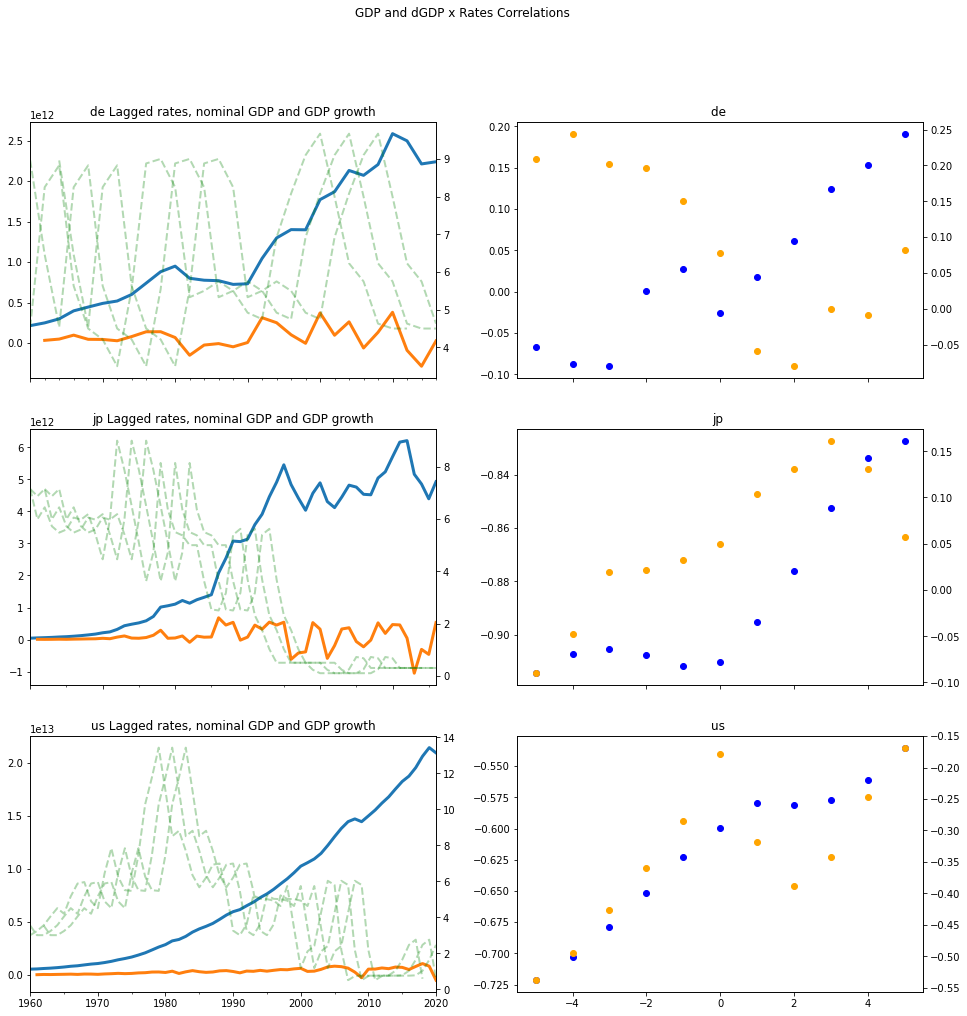

In [8]:
_, ax = plt.subplots(3, 2, figsize=(16, 16))
# _.tight_layout(h_pad=2 )

save_cdfs = {} # for the PPS section

for i, c in enumerate(countries):
    c = c.lower()
    cdf = df[["{}_r".format(c), "{}_g".format(c)]].dropna()
    
    # --- GDP Growth
    cdf['{}_dg'.format(c)] = cdf["{}_g".format(c)] - cdf["{}_g".format(c)].shift(1)
    
    # --- Lag rates forwards and backwards by 5 years
    deltas = range(-5, 6)
    for d in deltas:
        cdf["{c}_r_lag_{d}".format(c=c, d=d)] = cdf["{}_r".format(c)].shift(d)
    
    save_cdfs[c] = cdf
    
    # --- Correlate lagged rates to nominal GDP and dGDP
    corr_gdp = cdf.corr()["{}_g".format(c)].iloc[3:]
    corr_dgdp = cdf.corr()["{}_dg".format(c)].iloc[3:]
    
    # --- Plot
    ax01 = ax[i, 0].twinx()
    ax11 = ax[i, 1].twinx()
    
    # --- Nomainal GDP and dGDP
    cdf.plot(y=["{}_g".format(c), '{}_dg'.format(c)], ax=ax[i,0], lw=3);
    cdf.plot(
        y=["{}_r_lag_-2".format(c), "{}_r_lag_0".format(c), "{}_r_lag_2".format(c)], 
        ax=ax01,
        **{"alpha":0.3, "linestyle":"--", "lw":2}, c="g", legend=False
    )

    ax[i, 1].plot(deltas, corr_gdp, '.', c='blue', ms=12);
    ax11.plot(deltas, corr_dgdp, '.', c='orange', ms=12);
    
    # --- Titles, labels, similar
    ax[i, 0].set(title="{} Lagged rates, nominal GDP and GDP growth".format(c))
    ax[i, 1].set(title="{} ".format(c))
    ax[i, 0].get_legend().remove()
    _.suptitle("GDP and dGDP x Rates Correlations")

## Repeat for PPS

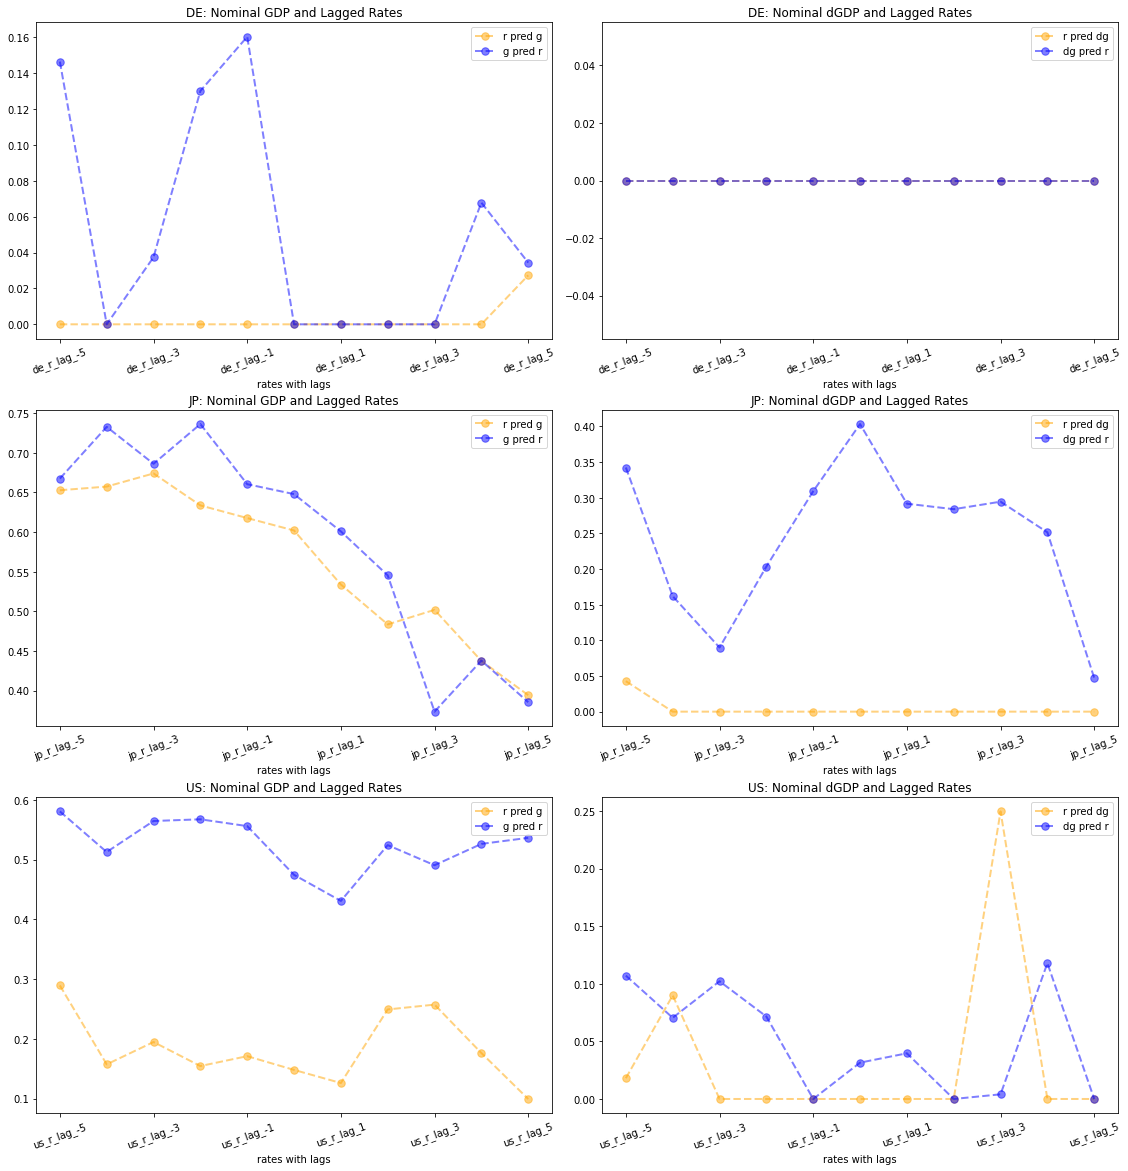

In [9]:
import ppscore as pps

_, ax = plt.subplots(3, 2, figsize=(16,16))
_.tight_layout(pad=2, h_pad=5)

save_pscores = {}

for i, c in enumerate(countries):
    c = c.lower()
    cdf = save_cdfs[c]
    deltas = range(-5, 6)
    
    # --- All PPS scores
    pscores = pps.matrix(cdf)
    save_pscores[c] = pscores
    
    # --- Select "x=rates with lags predict y=GDP"
    r_pred_g = pd.concat([
        pscores.loc[
            (pscores['x'] == "{c}_r_lag_{l}".format(c=c,l=l))
            &(pscores['y'] == "{}_g".format(c))] for l in deltas], ignore_index=True
    )
    
    # --- Select "x=GDP predicts y=rates with lags"
    g_pred_r = pd.concat([
        pscores.loc[
            (pscores['y'] == "{c}_r_lag_{l}".format(c=c,l=l))
            &(pscores['x'] == "{}_g".format(c))] for l in deltas], ignore_index=True
    )
    
    # --- Select "x=rates with lags predict y=dGDP"
    r_pred_dg = pd.concat([
        pscores.loc[
            (pscores['x'] == "{c}_r_lag_{l}".format(c=c,l=l))
            &(pscores['y'] == "{}_dg".format(c))] for l in deltas], ignore_index=True
    )
    
    # --- Select "x=dGDP predicts y=rates with lags"
    dg_pred_r = pd.concat([
        pscores.loc[
            (pscores['y'] == "{c}_r_lag_{l}".format(c=c,l=l))
            &(pscores['x'] == "{}_dg".format(c))] for l in deltas], ignore_index=True
    )
    
    # --- Plot
    r_pred_g.plot(
        x='x', y='ppscore', kind="line", ax=ax[i, 0],
        style=".--", c="orange", lw=2, ms=15, alpha=0.5,
        **{"label" : "r pred g"}
    )
    g_pred_r.plot(
        x='y', y='ppscore', kind="line", ax=ax[i, 0],
        style=".--", c="b", lw=2, ms=15, alpha=0.5,
        **{
            "title" : "{}: Nominal GDP and Lagged Rates".format(c.upper()),
            "xlabel" : "rates with lags",
            "label" : "g pred r"
          }
    )
    
    r_pred_dg.plot(
        x='x', y='ppscore', kind="line", ax=ax[i, 1],
        style=".--", c="orange", lw=2, ms=15, alpha=0.5,
        **{"label" : "r pred dg"}
    )
    dg_pred_r.plot(
        x='y', y='ppscore', kind="line", ax=ax[i, 1],
        style=".--", c="b", lw=2, ms=15, alpha=0.5,
        **{
            "title" : "{}: Nominal dGDP and Lagged Rates".format(c.upper()),
            "xlabel" : "rates with lags",
            "label" : "dg pred r"
          }
    )
    
    ax[i, 0].tick_params(axis='x', labelrotation = 20)
    ax[i, 1].tick_params(axis='x', labelrotation = 20)
#     _.suptitle("PPS Scores for Nominal GDP and dGDP")

#### Granger Causality

On a quick read, it seems I more or less intuited the gist of Granger causality in the introduction. In a line, 

"X causes Y" is tested by checking for:
$$
\mathbb{P}[Y_{t+1} \in A_{rbitrary} | \mathcal{I}(t)] \neq \mathbb{P}[Y_{t+1} \in A_{rbitrary} | \mathcal{I}_{-X}(t)]
$$

which reads: 

The probablility that "$Y$ happens at time $t+1$ given the status quo $\mathcal{I}$ at time $t$" is not the same as the probability that "$Y$ happens at time $t+1$ given the alternate-reality status quo $\mathcal{I}_{-X}$ at time $t$, where everything is the same except that $X$ didn't happen"

Sensible.

Note that for [`statsmodels.tsa.stattools.grangercausalitytests`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html),
```
x: The data for test whether the time series in the second column Granger causes the time series in the first column...
```

#### Critical F
Part of doing g-causality testing, I'll need to check F values against a critical F. However, I couldn't find a prepackaged solution for determining the critical value for an F test of arbitrary DoF that doesn't involve either dragging my poor eyeballs across a literal table of values or using an online calculator. Either would be tolerable for one or two hard coded examples, but i'm trying to do 30 of them, so I figured i'd just make a scrappy one myself.

- [F-distirbution formula and CDF](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3665.htm)

- [Resolving significance from F-dist](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3673.htm)

Note that the cumulative distribution function for the F is 🍌 so I think approximating AUC then grabbing the corresponding x value with calculus is probably easier. I'm thinking I just do one of these...

$$
\int_{x_a}^{\infty} f(t) dt = F(\mathcal{df}_1, \mathcal{df}_2, \infty) - F(\mathcal{df}_1, \mathcal{df}_2, x_a)
$$

... and use a simple optimiser to find the answer. Since the CDF across the entire function is 1, I would want the arithmetic on the right to equal the significance level $a$. E.g. for a 5% significant result, find the $x_{\text{5%}}$ value that gives $F(\mathcal{df}_1, \mathcal{df}_2, \infty) - F(\mathcal{df}_1, \mathcal{df}_2, x_{5\%}) = 0.05$

In [10]:
# --- Critical F estimation tool

from scipy.special import gamma
from scipy.integrate import simps
from scipy.optimize import minimize_scalar

def sig_x(df1, df2, significance):
    upper = 100
    lower = 0
    
    # --- General F distribution
    def general_f(x, df1, df2):
        numerator = gamma((df1 + df2)/2) * ((df1/df2)**(df1/2)) * (x ** (df1 / 2 -1))
        denominator = gamma(df1/2) * gamma(df2/2) * (1 + (df1 * x) / df2) ** ((df1+df2)/2)
        return numerator/denominator
    
    # --- AUC
    def auc(lower, upper):
        x = np.linspace(lower, upper, 1000)
        y = general_f(x, df1, df2)
        return simps(y, x, dx=0.001, axis=0)
    
    # --- Minimizer
    min_me = lambda x: abs(auc(lower=x, upper=upper) - significance)
    return minimize_scalar(min_me, method="Bounded", bounds=(0, 20))

In [11]:
# --- Granger causality

from statsmodels.tsa.stattools import grangercausalitytests as granger

L = 5 # test g-causlaity for lags 1 through L

g_results = {}

for c in countries:
    c = c.lower()
    cdf = save_cdfs[c]
    
    hn0 = cdf[["{}_r".format(c), "{}_g".format(c)]].dropna() # test for "GDP g-causes r"
    hn1 = cdf[["{}_g".format(c), "{}_r".format(c)]].dropna() # test for "r g-causes GDP"
    hd0 = cdf[["{}_r".format(c), "{}_dg".format(c)]].dropna() # test for "dGDP g-causes r"
    hd1 = cdf[["{}_dg".format(c), "{}_r".format(c)]].dropna() # test for "r g-causes dGDP"
    test_hn0 = granger(hn0, maxlag=L, verbose=False)
    test_hn1 = granger(hn1, maxlag=L, verbose=False)
    test_hd0 = granger(hd0, maxlag=L, verbose=False)
    test_hd1 = granger(hd1, maxlag=L, verbose=False)
    g_results[c] = {"hn0" : test_hn0, "hn1" : test_hn1, "hd0" : test_hd0, "hd1" : test_hd1}

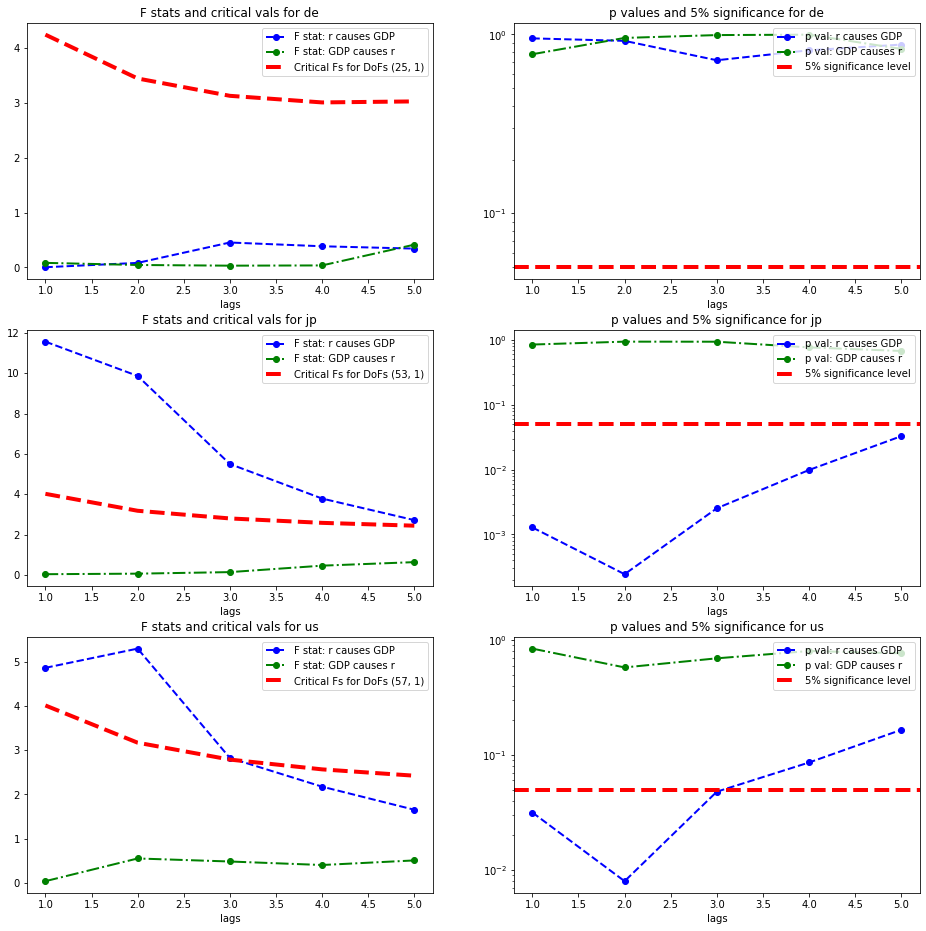

In [12]:
# --- Plot the nominal GDP Stats

_, ax = plt.subplots(3, 2, figsize=(16, 16))

significance = 0.05

for i, c in enumerate(countries):
    c = c.lower()
    lags = range(1, L+1)
    tests = g_results[c]
    
    # --- hn0: nominal GDP causes r
    f_hn0 = [tests["hn0"][l][0]["params_ftest"][0] for l in lags]
    p_hn0 = [tests["hn0"][l][0]["params_ftest"][1] for l in lags]
    
    ax[i, 0].plot(lags, f_hn0, 'o--', lw=2, c="b", label="F stat: r causes GDP")
    ax[i, 1].plot(lags, p_hn0, 'o--', lw=2, c="b", label="p val: r causes GDP")
    
    # --- hn1: r causes nominal GDP
    f_hn1 = [tests["hn1"][l][0]["params_ftest"][0] for l in lags]
    p_hn1 = [tests["hn1"][l][0]["params_ftest"][1] for l in lags]
    
    ax[i, 0].plot(lags, f_hn1, 'o-.', lw=2, c="g", label="F stat: GDP causes r")
    ax[i, 1].plot(lags, p_hn1, 'o-.', lw=2, c="g", label="p val: GDP causes r")
    
    # --- Common for both of the above
    dofs = [tests["hn1"][l][0]["params_ftest"][2:] for l in lags]
    crit_f = [sig_x(dof[1], dof[0], significance).x for dof in dofs]
    ax[i, 0].plot(lags, crit_f, '--', lw=4, ms=15, c="r",
                  label='Critical Fs for DoFs ({f1}, {f2})'.format(f1=int(dofs[0][0]),
                                                                  f2=int(dofs[0][1])))
    ax[i, 1].axhline(y=significance, color="r", linestyle="--", lw=4,
                     label="5% significance level")    
    
    # --- Titles, Labels, Legends
    ax[i, 0].set(
        title="F stats and critical vals for {}".format(c),
        xlabel="lags",
    )

    ax[i, 1].set(
        title="p values and {s}% significance for {c}".format(s=int(significance*100), c=c),
        xlabel="lags",
        yscale='log'
    )
    ax[i, 0].legend(loc="upper right")
    ax[i, 1].legend(loc="upper right")

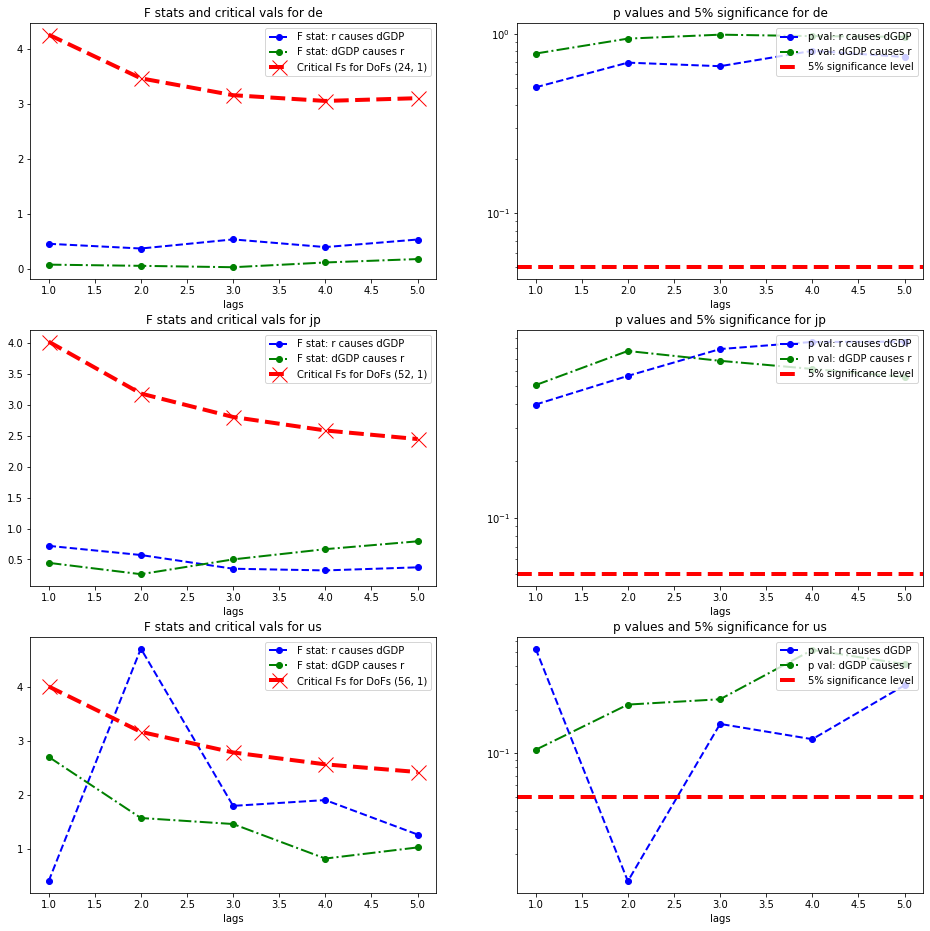

In [13]:
# --- Plot the dGDP Stats

_, ax = plt.subplots(3, 2, figsize=(16, 16))

significance = 0.05

for i, c in enumerate(countries):
    c = c.lower()
    lags = range(1, L+1)
    tests = g_results[c]
    
    # --- hn0: nominal GDP causes r
    f_hd0 = [tests["hd0"][l][0]["params_ftest"][0] for l in lags]
    p_hd0 = [tests["hd0"][l][0]["params_ftest"][1] for l in lags]
    
    ax[i, 0].plot(lags, f_hd0, 'o--', lw=2, c="b", label="F stat: r causes dGDP")
    ax[i, 1].plot(lags, p_hd0, 'o--', lw=2, c="b", label="p val: r causes dGDP")
    
    # --- hd1: r causes nominal GDP
    f_hd1 = [tests["hd1"][l][0]["params_ftest"][0] for l in lags]
    p_hd1 = [tests["hd1"][l][0]["params_ftest"][1] for l in lags]
    
    ax[i, 0].plot(lags, f_hd1, 'o-.', lw=2, c="g", label="F stat: dGDP causes r")
    ax[i, 1].plot(lags, p_hd1, 'o-.', lw=2, c="g", label="p val: dGDP causes r")
    
    # --- Common for both of the above
    dofs = [tests["hd1"][l][0]["params_ftest"][2:] for l in lags]
    crit_f = [sig_x(dof[1], dof[0], significance).x for dof in dofs]
    ax[i, 0].plot(lags, crit_f, 'x--', lw=4, ms=15, c="r",
                  label='Critical Fs for DoFs ({f1}, {f2})'.format(f1=int(dofs[0][0]),
                                                                  f2=int(dofs[0][1])))
    ax[i, 1].axhline(y=significance, color="r", linestyle="--", lw=4,
                     label="5% significance level")    
    
    # --- Titles, Labels, Legends
    ax[i, 0].set(
        title="F stats and critical vals for {}".format(c),
        xlabel="lags",
    )

    ax[i, 1].set(
        title="p values and {s}% significance for {c}".format(s=int(significance*100), c=c),
        xlabel="lags",
        yscale='log'
    )
    ax[i, 0].legend(loc="upper right")
    ax[i, 1].legend(loc="upper right")

#### GDP Japan
World Bank, Gross Domestic Product for Japan [MKTGDPJPA646NWDB], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MKTGDPJPA646NWDB, July 17, 2021.

#### Interest rate Japan
International Monetary Fund, Interest Rates, Discount Rate for Japan [INTDSRJPM193N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/INTDSRJPM193N, July 17, 2021.

#### GDP Germnay
??

#### Interest rate Germany
International Monetary Fund, Interest Rates, Discount Rate for Germany [INTDSRDEM193N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/INTDSRDEM193N, July 17, 2021.

#### GDP USA
U.S. Bureau of Economic Analysis, Gross Domestic Product [GDP], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/GDP, July 17, 2021.

#### Interest rate USA
International Monetary Fund, Interest Rates, Discount Rate for United States [INTDSRUSM193N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/INTDSRUSM193N, July 18, 2021.